In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [9]:
candidates = pd.read_csv('all_candidates.csv', index_col=0)
samples = pd.read_csv('params_inc_SNR.csv', index_col=0)
samples['net_snr'] = np.sqrt(samples['H1_snr']**2 + samples['L1_snr']**2 +samples['V1_snr']**2)

In [10]:
# write the FAR conversion as a function
def SNR_to_FAR(snr, FAR8=5500, alpha=0.18):
    """Calculate the FAR using the parameterisations from the Lynch paper"""
    FAR = FAR8*np.exp(-(snr-8)/alpha)
    return FAR

# use this parameterisation to estimate some FARs
samples['lynch_FAR'] = SNR_to_FAR(samples['net_snr'])

In [51]:
# we want to fit the snr_to_far relationship to the data and see if a different alpha (or FAR8) comes out
from scipy.optimize import curve_fit

def far_fn_both(snr, FAR8, alpha):
    """Calculate the FAR using the parameterisations from the Lynch paper"""
    FAR = FAR8*np.exp(-(snr-8)/alpha)
    return FAR

parameters, covariance = curve_fit(far_fn_both, candidates['snr'], candidates['combined_far'], p0=[5500, 0.18], method='trf')

fit_FAR8_both = parameters[0]
fit_alpha_both = parameters[1]
print(fit_FAR8_both, fit_alpha_both)

fitted_FAR_alpha_FAR8 = far_fn_both(candidates['snr'], fit_FAR8_both, fit_alpha_both)

# this fit only allows alpha to vary
def far_fn(snr, alpha):
    """Calculate the FAR using the parameterisations from the Lynch paper"""
    FAR = 5500*np.exp(-(snr-8)/alpha)
    return FAR

parameters, covariance = curve_fit(far_fn, candidates['snr'], candidates['combined_far'])

fit_alpha = parameters[0]
print(fit_alpha)

fitted_FAR_alpha = far_fn(candidates['snr'], fit_alpha)

1249.0678942643979 3.9758633656114513
2.9986941622891465


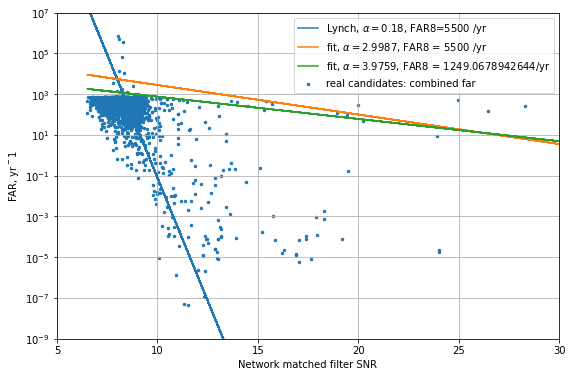

In [52]:
fig, ax = plt.subplots(figsize = (9, 6))
sc = ax.scatter(x=candidates['snr'], y=candidates['combined_far'], label='real candidates: combined far', s=6)
ax.set_yscale("log")
plt.ylabel('FAR, yr$^-1$')
plt.xlabel('Network matched filter SNR')
plt.semilogy(samples['net_snr'], samples['lynch_FAR'], '-', markersize=3, label=r'Lynch, $\alpha = 0.18$, FAR8=5500 /yr')
plt.semilogy(candidates['snr'], fitted_FAR_alpha, '-', markersize=3, label=r'fit, $\alpha = {}$, FAR8 = 5500 /yr'.format(np.round(fit_alpha, 4)))
plt.semilogy(candidates['snr'], fitted_FAR_alpha_FAR8, '-', markersize=3, label=r'fit, $\alpha = {}$, FAR8 = {}/yr'.format(np.round(fit_alpha_both,4), np.round(fit_FAR8_both, 10)))
#plt.scatter(x=data_release_snr_far_round_drop_sat['snr'], y=data_release_snr_far_round_drop_sat['far'], label='real candidates: false_alarm_rate', s=6)
plt.xlim((5,30))
plt.ylim((1e-9,1e7))
# fig.colorbar(sc, label='$p_{astro}$')
plt.legend()
plt.grid()
plt.savefig('snr_far_relationship.png')

### Next
These fits are rather poor so let's try different ideas:
* fit in log space
* fit a power law
* look into scipy curve_fit and see what the fitting entails
    * uses non-linear least squares

1102.6528779699217 872.62560821532


/data/wiay/johnny/phd1/phd1/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


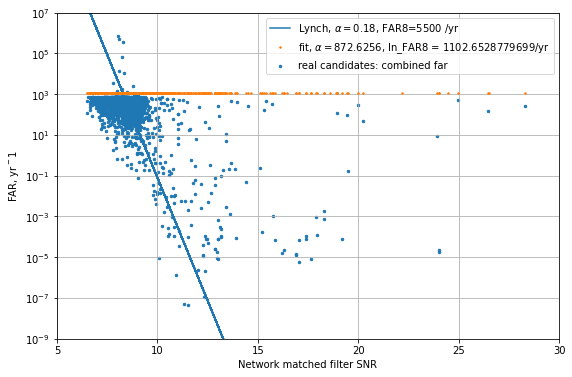

In [50]:
# define the funtion in log space and fit
def ln_FAR_SNR(SNR, lnFAR8, alpha):
    lnFAR = lnFAR8 + (-SNR-8)/alpha
    return lnFAR

parameters, covariance = curve_fit(ln_FAR_SNR, candidates['snr'], candidates['combined_far'], method='trf')

fit_lnFAR8 = parameters[0]
fit_ln_alpha = parameters[1]
print(fit_lnFAR8, fit_ln_alpha)

fitted_lnFAR = ln_FAR_SNR(candidates['snr'], fit_lnFAR8, fit_ln_alpha)
# ln far8 is just a constant so I don't need to exp this
fitted_FAR = np.exp(fitted_lnFAR)

# plot this fit
fig, ax = plt.subplots(figsize = (9, 6))
sc = ax.scatter(x=candidates['snr'], y=candidates['combined_far'], label='real candidates: combined far', s=6)
ax.set_yscale("log")
plt.ylabel('FAR, yr$^-1$')
plt.xlabel('Network matched filter SNR')
plt.semilogy(samples['net_snr'], samples['lynch_FAR'], '-', markersize=3, label=r'Lynch, $\alpha = 0.18$, FAR8=5500 /yr')
plt.semilogy(candidates['snr'], fitted_lnFAR, '.', markersize=3, label=r'fit, $\alpha = {}$, ln_FAR8 = {}/yr'.format(np.round(fit_ln_alpha,4), np.round(fit_lnFAR8, 10)))
plt.xlim((5,30))
plt.ylim((1e-9,1e7))
# fig.colorbar(sc, label='$p_{astro}$')
plt.legend()
plt.grid()
#plt.savefig('snr_far_relationship.png')

This fitting of the log form of the equation again looks pretty poor.

Let's attempt a power-law.

2.1249917806263525


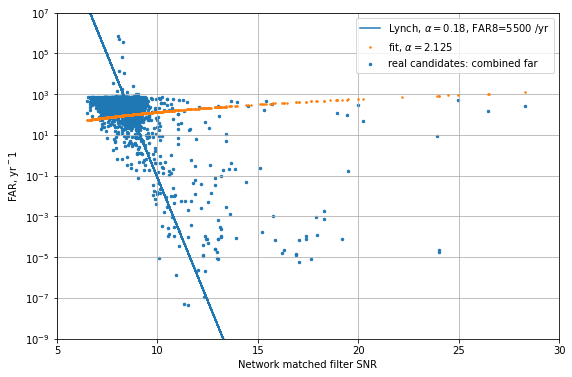

In [48]:
# define the funtion in log space and fit
def FAR_SNR_pow(SNR, alpha):
    FAR = SNR**(alpha)
    return FAR

parameters, covariance = curve_fit(FAR_SNR_pow, candidates['snr'], candidates['combined_far'], method='trf')

fit_pow_alpha = parameters[0]
print(fit_pow_alpha)

fitted_pow_FAR = FAR_SNR_pow(candidates['snr'], fit_pow_alpha)

# plot this fit
fig, ax = plt.subplots(figsize = (9, 6))
sc = ax.scatter(x=candidates['snr'], y=candidates['combined_far'], label='real candidates: combined far', s=6)
ax.set_yscale("log")
plt.ylabel('FAR, yr$^-1$')
plt.xlabel('Network matched filter SNR')
plt.semilogy(samples['net_snr'], samples['lynch_FAR'], '-', markersize=3, label=r'Lynch, $\alpha = 0.18$, FAR8=5500 /yr')
plt.semilogy(candidates['snr'], fitted_pow_FAR, '.', markersize=3, label=r'fit, $\alpha = {}$'.format(np.round(fit_pow_alpha,4)))
plt.xlim((5,30))
plt.ylim((1e-9,1e7))
# fig.colorbar(sc, label='$p_{astro}$')
plt.legend()
plt.grid()
#plt.savefig('snr_far_relationship.png')

53.307778983907376 -27.644274879789787


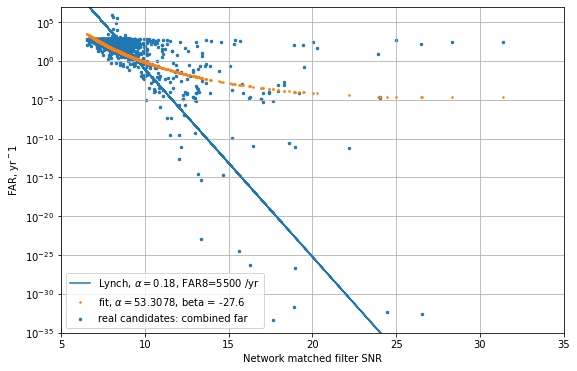

In [68]:
# define the funtion in log space and fit
def FAR_SNR_pow(SNR, alpha, beta):
    FAR = SNR**(beta)*np.exp(SNR+alpha)
    return FAR

parameters, covariance = curve_fit(FAR_SNR_pow, candidates['snr'], candidates['combined_far'], method='trf')

fit_pow_alpha = parameters[0]
fit_pow_beta = parameters[1]
print(fit_pow_alpha, fit_pow_beta)

fitted_pow_FAR = FAR_SNR_pow(candidates['snr'], fit_pow_alpha, fit_pow_beta)

# plot this fit
fig, ax = plt.subplots(figsize = (9, 6))
sc = ax.scatter(x=candidates['snr'], y=candidates['combined_far'], label='real candidates: combined far', s=6)
ax.set_yscale("log")
plt.ylabel('FAR, yr$^-1$')
plt.xlabel('Network matched filter SNR')
plt.semilogy(samples['net_snr'], samples['lynch_FAR'], '-', markersize=3, label=r'Lynch, $\alpha = 0.18$, FAR8=5500 /yr')
plt.semilogy(candidates['snr'], fitted_pow_FAR, '.', markersize=3, label=r'fit, $\alpha = {}$, beta = {}'.format(np.round(fit_pow_alpha,4), np.round(fit_pow_beta, 1)))
plt.xlim((5,35))
plt.ylim((1e-35,1e7))
# fig.colorbar(sc, label='$p_{astro}$')
plt.legend()
plt.grid()
#plt.savefig('snr_far_relationship.png')

Perhaps the Lynch parameterisation isn't so bad.

In [70]:
# chosen snr to far function
def far_fn(snr, FAR8=5500, alpha=0.18):
    """Calculate the FAR using the parameterisations from the Lynch paper"""
    FAR = FAR8*np.exp(-(snr-8)/alpha)
    return FAR

samples['FAR'] = far_fn(samples['net_snr'])
samples.to_csv('params_inc_FAR.csv')

In [71]:
samples.head()

,mass_1,mass_ratio,a_1,a_2,cos_tilt_1,cos_tilt_2,redshift,mass_2,chi_eff,tilt_1,...,theta_jn,psi,phase,ra,dec,phi_12,phi_jl,net_snr,lynch_FAR,FAR
0,14.206189,0.753297,0.084464,0.150304,-0.261760,0.392646,0.906271,10.701485,0.012746,1.835642,...,0.478923,2.518351,4.208321,3.068214,0.029949,1.709171,6.212235,4.715177,4.632437e+11,4.632437e+11
1,7.631592,0.987168,0.301969,0.514466,-0.610410,-0.613718,1.837756,7.533664,-0.249606,2.227374,...,2.060811,2.176761,3.695127,3.062258,0.902357,5.343215,3.462008,0.762437,1.595041e+21,1.595041e+21
2,6.088737,0.993740,0.235612,0.437827,0.873063,0.821194,2.090188,6.050621,0.282381,0.509347,...,2.746061,0.839684,2.333354,5.323210,1.533282,3.987185,4.133948,1.630003,1.286929e+19,1.286929e+19
3,13.368498,0.656860,0.519649,0.126563,0.212090,-0.385168,1.802572,8.781230,0.047193,1.357083,...,1.376382,2.458206,0.808485,3.241303,0.622675,1.394951,0.676842,0.953321,5.523524e+20,5.523524e+20
4,23.997822,0.479771,0.313633,0.007355,0.270814,0.404514,1.759925,11.513460,0.058363,1.296558,...,1.917434,0.655696,5.435143,1.227290,1.416742,0.354682,3.028431,1.492217,2.766927e+19,2.766927e+19
